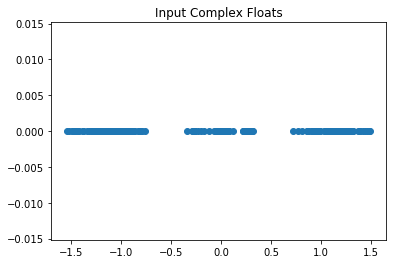

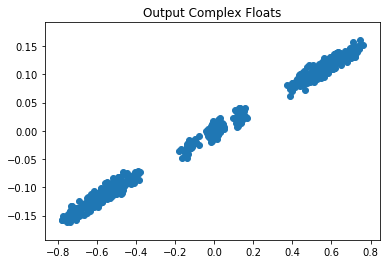

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

def complexSignals(inFile, outFile):
    BytesIn = np.fromfile(inFile, dtype = 'uint8')
    floatsIn = np.fromfile(inFile, dtype = 'float32')
    complexIn = np.array([complex(floatsIn[2*i], floatsIn[2*i + 1]) for i in range(len(floatsIn) // 2)])
    BitsIn = np.unpackbits(BytesIn)

    floatsOut = np.fromfile(outFile, dtype = 'float32')
    complexOut = np.array([complex(floatsOut[2*i], floatsOut[2*i + 1]) for i in range(len(floatsOut) // 2)])
    BytesOut = np.fromfile(outFile, dtype = 'uint8')
    BitsOut = np.unpackbits(BytesOut)
    
    return complexIn, complexOut

def plot(complexIn, complexOut):
    plt.scatter(complexIn.real, complexIn.imag)
    plt.title("Input Complex Floats")
    plt.show()
    plt.clf()

    plt.scatter(complexOut.real, complexOut.imag)
    plt.title("Output Complex Floats")
    plt.show()
    plt.clf()
    
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

In [3]:
def correlate(complexIn, complexOut, samples):
    result = np.correlate(complexIn[:samples], complexIn[:samples], mode='full')
    autoCorrIn = np.sqrt(result[result.size//2:][0])
    crossCorArray = [np.correlate(complexIn[:samples], complexOut[start: start + samples]) / np.sqrt(np.correlate(complexOut[start: start + samples], complexOut[start: start + samples]))
                     for start in range(len(complexOut) - samples + 1)] / autoCorrIn
    maxCrossCor = max(crossCorArray) 
    lag = np.argmax(crossCorArray)
    maxCorrOutput = complexOut[lag: lag + samples]
    
    return lag, maxCrossCor, crossCorArray, maxCorrOutput
    

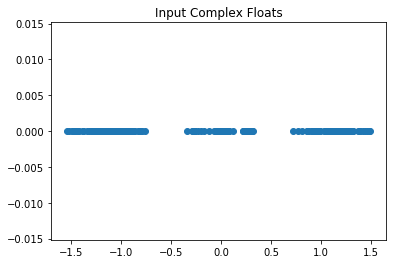

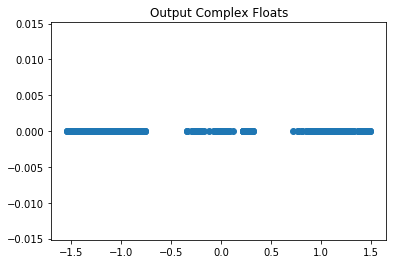

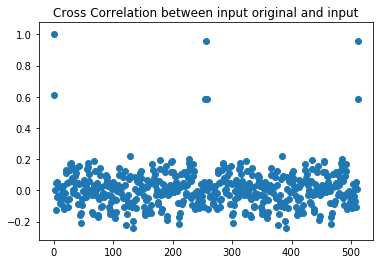

In [4]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/input_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and input")
plt.show()

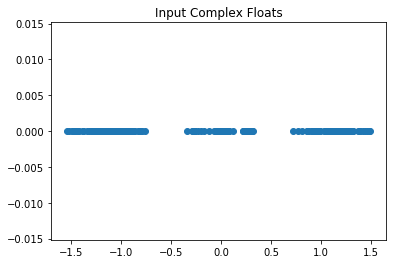

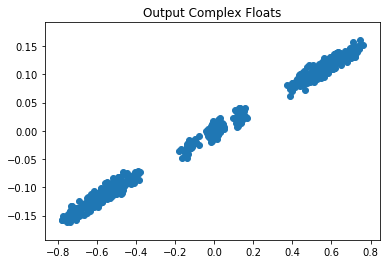

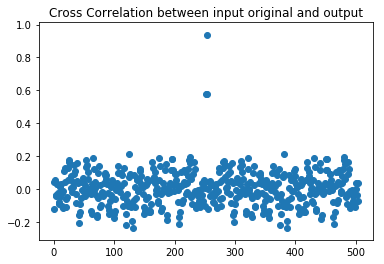

In [5]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and output")
plt.show()

In [6]:
import numpy.linalg

def constructMatrix(complexIn, numTaps):
    matrix = []
    for i in range(len(complexIn) - numTaps + 1):
        matrix.append(complexIn[i: i + numTaps])
        
    return np.matrix(matrix)

def bestEstimator(X, y, l=0.1):
    # Returns the best estimator in ridge regression
    XTX = X.T.dot(X)
    ridge = XTX + l*np.identity(XTX.shape[0])
    rhs = X.T.dot(y)
    return np.linalg.solve(ridge, rhs)

def iterativeBestEstimator(complexIn, maxCorrOutput):
    numTaps = 1
    while True:
        inputMatrix = constructMatrix(complexIn, numTaps)
        ynew = np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))
        tapsOld = bestEstimator(inputMatrix, ynew)
        oldError = np.linalg.norm(inputMatrix.dot(tapsOld) - ynew)
        inputMatrix = constructMatrix(complexIn, numTaps + 1)
        ynew = np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))
        tapsNew = bestEstimator(inputMatrix, ynew)
        newError = np.linalg.norm(inputMatrix.dot(tapsNew) - ynew)
        if newError > oldError:
            return tapsOld, numTaps
        numTaps += 1


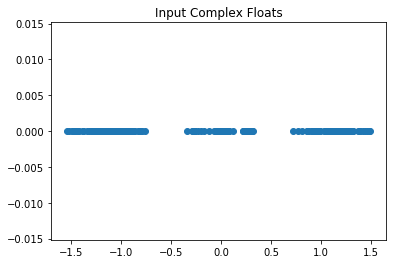

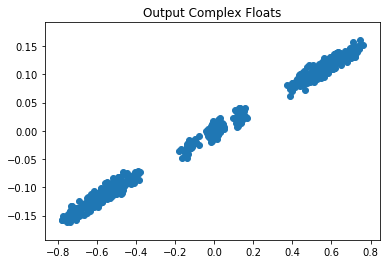

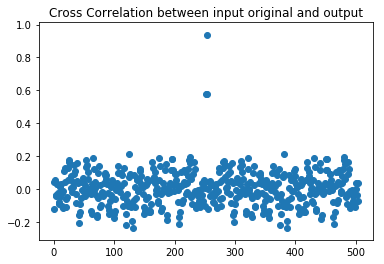

matrix([[ 0.49990394+0.09970856j]])

In [7]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and output")
plt.show()
# ACTUAL: 0.5 + 0.1j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=1)
bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1)))


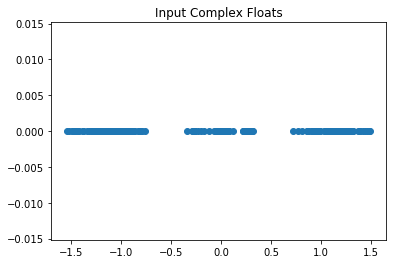

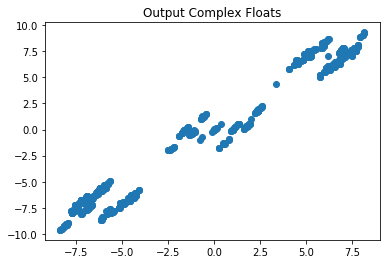

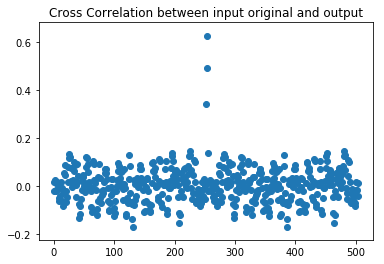

matrix([[ 6.30919771+6.38068604j],
        [-1.31960168-0.26046507j],
        [ 0.79765945+0.19217823j]])

In [8]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless_3-1dominant'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and output")
plt.show()

# ACTUAL: 5.0 + 6.1j, 0.8 + 0.2j, 0.7 + 0.05 j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=3)
bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1)))

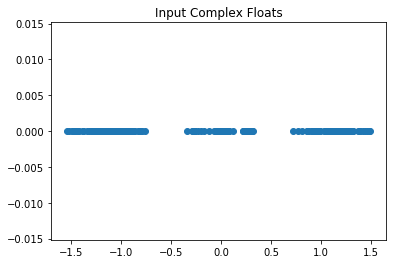

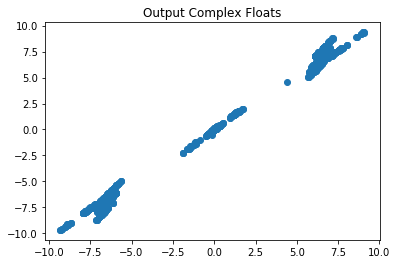

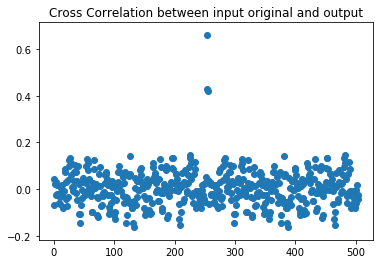

[[ 5.92650071+6.16317734j]
 [-0.01509533+0.14085338j]
 [ 0.46532695+0.08306225j]]


In [9]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless_3-1dominant_shuffle'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and output")
plt.show()

# ACTUAL: 0.8 + 0.2j, 5.0 + 6.1j, 0.7 + 0.05 j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=3)
print(bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))))

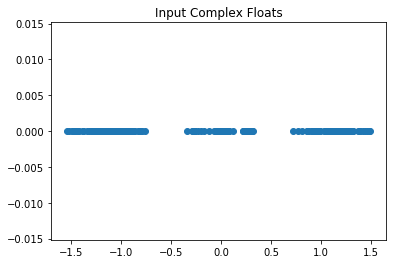

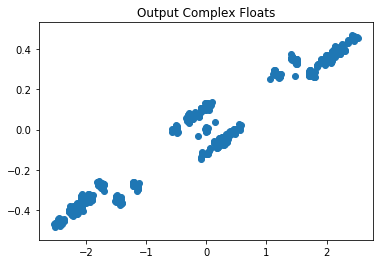

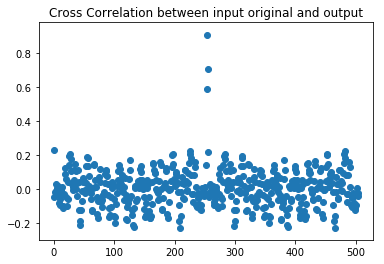

254 256
[[ 1.72572083+0.26658364j]
 [-0.31131947+0.04161779j]
 [ 0.42535563+0.03312155j]]


In [11]:
inFile = 'dumpfiles/input_complex_noiseless_original'
outFile = 'dumpfiles/output_complex_noiseless_3eq'
complexIn, complexOut = complexSignals(inFile, outFile)
plot(complexIn, complexOut)

lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
plt.scatter(np.arange(len(corrArray)), corrArray)
plt.title("Cross Correlation between input original and output")
plt.show()
print(lag, len(complexIn))

# ACTUAL: 0.5 + 0.1j, 0.8 + 0.2j, 0.7 + 0.05 j
lag, maxCrossCor, corrArray, maxCorrOutput = correlate(complexIn, complexOut, len(complexIn))
inputMatrix = constructMatrix(complexIn, numTaps=3)
print(bestEstimator(inputMatrix, np.array(maxCorrOutput[:inputMatrix.shape[0]]).reshape((-1, 1))))

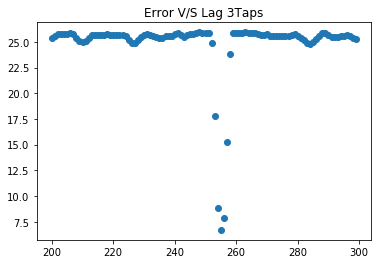

6.71045353687 255
[[ 0.70408883+0.05182693j]
 [ 0.79143795+0.19673512j]
 [ 0.51470871+0.10418734j]]


In [26]:
inputMatrix = constructMatrix(complexIn, numTaps=3)
taps, errors, lags = [], [], []
for lag in range(200, 300):
    ynew = np.array(complexOut[lag: lag + inputMatrix.shape[0]]).reshape((-1, 1))
    tapsOld = bestEstimator(inputMatrix, ynew)
    error = np.linalg.norm(inputMatrix.dot(tapsOld) - ynew)
    taps.append(tapsOld)
    errors.append(error)
    lags.append(lag)

i = np.argmin(errors)
plt.scatter(lags, errors)
plt.title("Error V/S Lag 3Taps")
plt.show()
print(errors[i], lags[i])
print(taps[i])

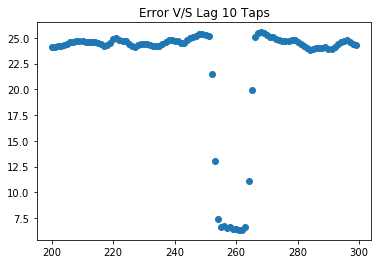

6.36491979858 262
[[ 0.00496076-0.00169415j]
 [-0.01463491+0.00151484j]
 [ 0.02364662-0.00287147j]
 [-0.02664112+0.00356092j]
 [ 0.01682212-0.00722892j]
 [ 0.00352342+0.01339872j]
 [-0.02567628-0.01797807j]
 [ 0.73632442+0.06881144j]
 [ 0.76678626+0.18539019j]
 [ 0.52538853+0.10866953j]]


In [27]:
inputMatrix = constructMatrix(complexIn, numTaps=10)
taps, errors, lags = [], [], []
for lag in range(200, 300):
    ynew = np.array(complexOut[lag: lag + inputMatrix.shape[0]]).reshape((-1, 1))
    tapsOld = bestEstimator(inputMatrix, ynew)
    error = np.linalg.norm(inputMatrix.dot(tapsOld) - ynew)
    taps.append(tapsOld)
    errors.append(error)
    lags.append(lag)

i = np.argmin(errors)
plt.scatter(lags, errors)
plt.title("Error V/S Lag 10 Taps")
plt.show()
print(errors[i], lags[i])
print(taps[i])

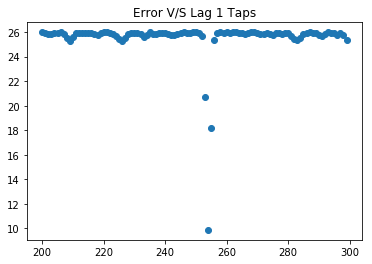

9.89733550468 254
[[ 1.53660254+0.29233413j]]


In [32]:
inputMatrix = constructMatrix(complexIn, numTaps=1)
taps, errors, lags = [], [], []
for lag in range(200, 300):
    ynew = np.array(complexOut[lag: lag + inputMatrix.shape[0]]).reshape((-1, 1))
    tapsOld = bestEstimator(inputMatrix, ynew)
    error = np.linalg.norm(inputMatrix.dot(tapsOld) - ynew)
    taps.append(tapsOld)
    errors.append(error)
    lags.append(lag)

i = np.argmin(errors)
plt.scatter(lags, errors)
plt.title("Error V/S Lag 1 Taps")
plt.show()
print(errors[i], lags[i])
print(taps[i])

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

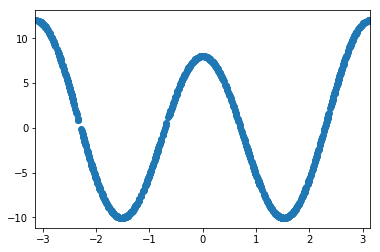

In [24]:
x = np.random.uniform(-np.pi, np.pi, 1000)
y = -2*np.cos(x) + 10 * np.cos(x*2)
plt.scatter(x, y)
plt.xlim((-np.pi, np.pi))
plt.show()
# a - b = 8
# a + b = 12